# Extract Cropped Images

In [ ]:
# IMPORTS
import os
import glob 
import warnings
import numpy as np
import pandas as pd
from osgeo import gdal
from pyproj import Transformer
import matplotlib.pyplot as plt

In [ ]:
# SETTINGS
warnings.filterwarnings('ignore')

In [ ]:
# MAIN
for occ_status in ["present", "absent"]:
    path = glob.glob('../../db/___COPERNICUS-S3-OLCI/*.tif')
    absent=pd.read_csv(f'../../db/occurrence/processed/{occ_status}.csv')

    # Create transformer from lat/lon to image CRS (assuming EPSG:3857)
    transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)

    # Transform all points in your CSV
    absent['x'], absent['y'] = transformer.transform(
        absent['decimalLongitude'].values,
        absent['decimalLatitude'].values
    )

    output_dir = f'../../db/___trn_val_tst/raw/patches_{occ_status}' 
    os.makedirs(output_dir, exist_ok=True)

    for p in path:
        img = gdal.Open(p)
        name = p.split('/')[-1]
        year = int(name.split('_')[0])
        bands = img.RasterCount
        
        geotransform = img.GetGeoTransform()
        pixel_width = geotransform[1]
        pixel_height = geotransform[5]

        minlon = geotransform[0]
        maxlat = geotransform[3]
        maxlon = minlon + pixel_width * img.RasterXSize
        minlat = maxlat + pixel_height * img.RasterYSize

        absent_subset = absent[
            (absent['year'] == year) &
            (absent['x'] >= minlon) &
            (absent['x'] < maxlon) &
            (absent['y'] >= minlat) &
            (absent['y'] < maxlat)
        ]

        for idx, (x, y) in enumerate(zip(absent_subset['x'], absent_subset['y'])):
            # Compute pixel coordinates in image CRS
            px = int((x - minlon) / pixel_width)
            py = int((y - maxlat) / pixel_height)  # pixel_height is negative for north-up images

            # Compute patch boundaries
            x_start = max(px - 32, 0)
            x_end = min(px + 32, img.RasterXSize)
            y_start = max(py - 32, 0)
            y_end = min(py + 32, img.RasterYSize)

            # Read all bands and crop patch
            img_np = np.dstack([img.GetRasterBand(i+1).ReadAsArray() for i in range(img.RasterCount)])
            patch = img_np[y_start:y_end, x_start:x_end, :]

            # Save patch as GeoTIFF
            driver = gdal.GetDriverByName('GTiff')
            out_path = os.path.join(output_dir, f"{year}_{idx}.tif")
            out_ds = driver.Create(
                out_path,
                patch.shape[1],  # width
                patch.shape[0],  # height
                patch.shape[2],  # number of bands
                gdal.GDT_Float32
            )

            # Compute new geotransform for patch
            new_geotransform = (
                minlon + x_start * pixel_width,
                pixel_width,
                0,
                maxlat + y_start * pixel_height,
                0,
                pixel_height
            )
            out_ds.SetGeoTransform(new_geotransform)
            out_ds.SetProjection(img.GetProjection())

            # Write each band
            for b in range(patch.shape[2]):
                out_ds.GetRasterBand(b+1).WriteArray(patch[:, :, b])

            out_ds.FlushCache()
            out_ds = None  # close file

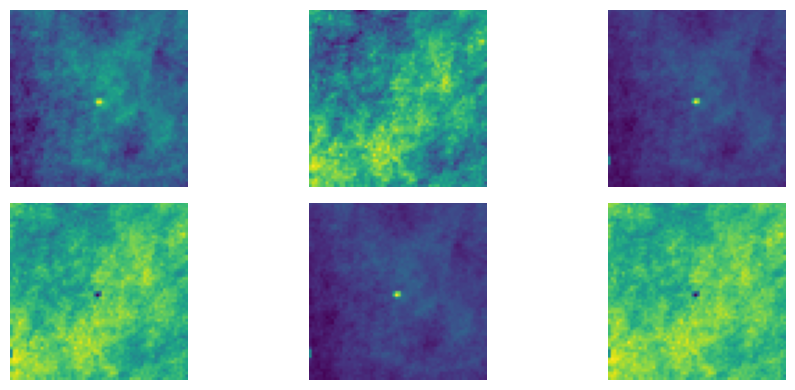

In [ ]:
# VIEW SAMPLE IMAGE

# Open image.
image = gdal.Open('../../db/___trn_val_tst/patches_present/2016_0.tif')

# Fetch and read the bands.
bands = [image.GetRasterBand(i).ReadAsArray() for i in range(1, 6+1)]

# Plot each band separately.
plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(bands[i],)
    plt.axis('off')
plt.tight_layout()
plt.show()